# Общее описание

## Задание
Построить модель для классификации изображений автомобилей для этого взять предобученую на imagenet сеть Xception и дообучить под нашу задачу. Улучшить результат baseline.

### Что хочется попробовать
* сделать прототип на базе Flask - 
* разобраться что такое головы, как их размораживают, как это влияет на обучение - еще раз пройду эту часть на платформе
* попасть в топ 10 - даже в топ 100 не попала, не поняла, как правильно оптимизировать модель - чтобы с этим разобраться 
* сравнить разные модели/ архитектуры? - не успела попробовать resnet50 и не все удается запустить в каггле
* добавить еще данных - успела только найти несколько датасетов
* сделать EDA для картинок - попробовала применить рекомндации отсюда https://datascience.stackexchange.com/questions/29223/exploratory-data-analysis-with-image-datset - но не разобралась, как правильно должен проходить первичный просмотр картинок и их отбор - отсмотрела вручную 
* проверить точность предсказаний модели (например, как здесь https://www.tensorflow.org/tutorials/keras/classification)

### Что еще можно сделать (или не получилось прикрутить за несколько часов)
* посмотреть на весь датасет с t-SNE visualization
* протестировать ResNet50 из tensorflow.keras.applications
* добавить tensorboard for visualisation
* добавить еще данных, например, https://paperswithcode.com/dataset/stanford-cars
* https://arxiv.org/abs/1803.09820 подбор гиперпараметров - лернинг рейт, батч сайз, activation function (Relu для скрытых слоев), optimizer 
* добавить наивную модель, например, с помощью catboost (?) - пока считаем за наивную модель baseline


## Резюме
### Что было сделано
1. Загружены все данные, импортированы библиотеки
2. Проведен первичный анализ данных
3. Сделано несколько версий с аугментацией фото
4. Протестировала несколько вариантов efficientnet c fine-tuning
5. Добавила tta

* лучший скор - 0.94621

Выполнила - Елисеева Алина, truelove077@gmail.com, #46_group_dst-32.
Срок сдачи работы - 21.07.2021

### Основная идея - берем предобученую на imagenet сеть Xception и дообучаем под нашу задачу.

## Загрузка библиотек

In [3]:
pip install -U efficientnet

     |████████████████████████████████| 50 kB 687 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-1idzxy2z
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-1idzxy2z
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=8171750e4b8fdfcca457bf687f9243deb34c90465a8c1fc9c4666ea040ab1db6
  Stored in directory: /tmp/pip-ephem-wheel-cache-t81q6t_1/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
import os
import zipfile
import tarfile

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.callbacks import Callback
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.layers import *

import albumentations as A
from ImageDataAugmentor.image_data_augmentor import *

import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split, StratifiedKFold

import efficientnet.keras as efn 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']


sample-submission.csv - пример данных, которые нужно будет загрузить на kaggle после распознавания тестовой выборки. Формат: название изображения, номер класса; в файле у всех изображений номер класса 0, потому что это лишь пример.

test.zip содержит тестовые данные, всего 6675 изображений разных размеров.

train.zip содержит папки с названиями 0, 1, ..., 9, соответствующими номеру класса изображения. В каждой папке пронумерованные изображения, например 219226.jpg, но номера не начинаются с единицы. Всего 15561 изображение.

train.csv содержит список всех тренировочных изображений.

### Где тестировала?

Протестила перед стартом - colab (не разобралась, как работать с большими файлами), deepnote (в бесплатной версии не хватает мощности), kaggle, на локальной машине (не хватило мощности для обучения). Пришлось вернуться к kaggle.

# Setup

In [6]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "./car/" 

In [7]:
!pip3 freeze > requirements.txt  # фиксируем версии всех пакетов для воспроизводимости результата

In [8]:
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0
# from tensorflow import set_random_seed


In [9]:
set_random_seed(RANDOM_SEED)

NameError: name 'set_random_seed' is not defined

# EDA / Анализ данных

Посмотрим на данные, которые у нас есть

In [12]:
# загружаем данные
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [8]:
# в датасете две колонки с id (object) и Category (int64), пропусков нет
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
# распределение достаточно равномерное
train_df.Category.value_counts()

<AxesSubplot:>

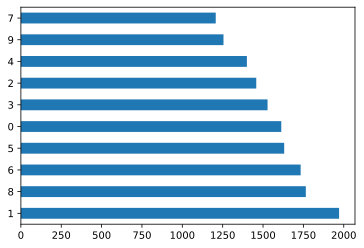

In [13]:
# заметно больше изображений 1 класса и меньше всего 7
train_df['Category'].value_counts().plot(kind='barh')

In [13]:
# распаковываем картинки
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


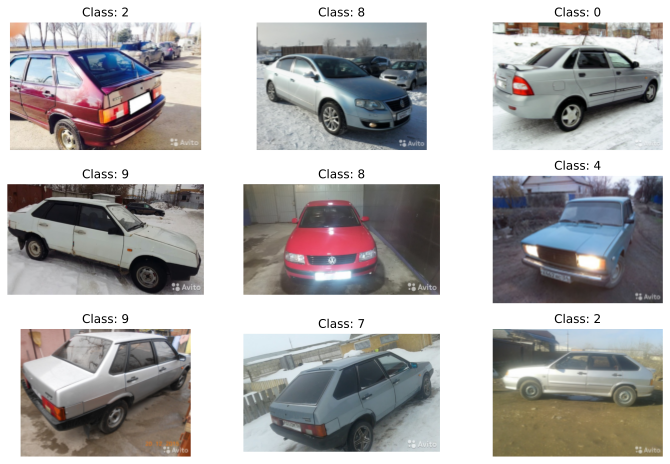

In [16]:
# посмотрим на рандомные картинки из датасета
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

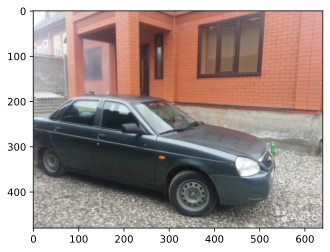

(640, 480)

In [22]:
# посмотрим на размер картинок, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(PATH+'train/0/12208.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Выводы:

* Для классификации представлены фотографии 10 категорий авто
 - 0 - Lada Priora
 - 1 - Ford Focus
 - 2 - Lada Samara
 - 3 - Lada 110
 - 4 - Lada 2107
 - 5 - Lada Niva
 - 6 - Lada Kalina
 - 7 - Lada Спутник
 - 8 - volkswagen passat
 - 9 - Lada Спутник (другой кузов?)
* Категории достаточно сбалансированны по кол-ву фото - исключая то, что несколько больше изображений 1 класса и меньше всего 7.
* Визуально заметила, что размеры фотографий отличаются, но в основном 640 на 480. Цветные.
* Всего 22236 фото в том числе:15561 фото в трейне и 6675 в тесте
* Количество фото в трейне не достаточно для хорошего обучения модели нейронной сети, поэтому будем применять различные виды аугментации данных.

# Data

In [14]:
# Первая аугментация данных, пробная

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [15]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    PATH +'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH +'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH +'test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.
Found 6675 validated image filenames.


# Model

### подгружаем предобученую сеть Xception

In [ ]:
# Загружаем предобученную сеть Xception без головы:

# base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [14]:
#использую EfficientNetB0 она в топе и тратит меньше ресурсов по сравнению с другими моделями
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape = input_shape)

16809984/16804768 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [15]:
# Устанавливаем новую "голову"

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# версия два - не улучшила скор
# base_model.trainable = True
# model=M.Sequential()
# model.add(base_model)
# model.add(L.GlobalAveragePooling2D())
# model.add(L.Dense(1024, activation='relu'))
# model.add(L.BatchNormalization())
# model.add(L.Dropout(0.25))
# # let's add a fully-connected layer
# model.add(L.Dense(256, activation='relu'))
# model.add(L.Dropout(0.25))
# model.add(L.Dense(256, activation='relu'))
# model.add(L.Dropout(0.25))
# model.add(L.Dense(64, activation='relu',
#                       bias_regularizer=l2(1e-4),
#                       activity_regularizer=l2(1e-5)))
# model.add(L.Dropout(0.25))
# model.add(L.Dense(CLASS_NUM, activation='softmax'))

# # this is the model we will train
# model.compile(loss="categorical_crossentropy",
#               optimizer=optimizers.Adam(lr=LR),
#               metrics=["accuracy"])

In [ ]:
model.summary()

## Fit

Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели, чтобы в нужный момент можно было его подгрузить и дообучить модель:

In [16]:
# Рекомендую добавть еще функции из https://keras.io/callbacks/
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

# Для про - попробуй добавить разные техники управления Learning Rate
# Например:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
# http://teleported.in/posts/cyclic-learning-rate/

In [21]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# попробуй применить transfer learning с fine-tuning
# Сначала замораживаем все слои кроме новой "головы"
# Потом, когда мы научили последние слои (голову) под новую задачу, можно разморозить все слои и пройтись маленьким лернинг рейтом

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Посмотрим на графики обучения:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Выводы:
Обучала EfficientNetB0 - очень быстро. По графикам обучения, не похоже, что нужно увеличивать количество эпох. Скор улучшился до 0.93602 с 0.93438.
Потом попорбовала модель с добавлением связанных слоев, Ухудшила результат и скор упал до 0.91460.

Вместо EfficientNetB0 пробовала установить EfficientNetB3 и EfficientNetB7, так как согласно https://kobiso.github.io/Computer-Vision-Leaderboard/imagenet, они должны давать большую точность, но на них не хватило мощности, слишком большое количество параметров. Нашла рекомендации для решения https://stackoverflow.com/questions/59394947/how-to-fix-resourceexhaustederror-oom-when-allocating-tensor/59395251

## step 2

Результаты бенчмарка у albumentations самые высокие (https://github.com/albumentations-team/albumentations#benchmarking-results), поэтому добавим именно эту библиотеку для аугментации данных.

In [23]:
import albumentations as A

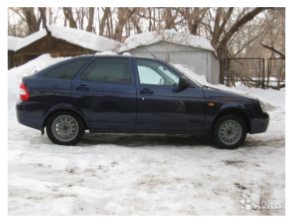

In [24]:
# для подбора параметров использовала https://albumentations-demo.herokuapp.com/

import cv2
from matplotlib import pyplot as plt
import albumentations as A
def view_transform(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)
figure = cv2.imread(PATH+'/train/0/100380.jpg')
figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)
view_transform(figure)

# потом проверяла разные параметры на исходных данных
# transform = A.RandomSizedCrop(p=0.5, min_max_height=(100,400), height=480, width=640, w2h_ratio=1.0, interpolation=0)
# # random.seed()
# augmented_image = transform(image=figure)['image']
# view_transform(augmented_image)

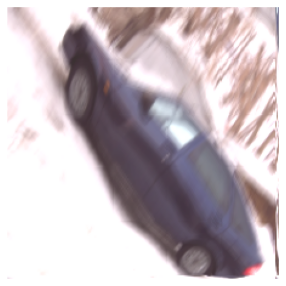

In [25]:
# трансформируем картинку
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=.1),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.RandomBrightnessContrast(),            
    ], p=0.3)
])
random.seed(42) 
augmented_image = transform(image=figure)['image']
view_transform(augmented_image)
# разобраться с обрезкой, чтобы убирал фон, оставлял только машину
# в принципе не поняла как правильно делать crop - пробовала randomcrop,centercrop - меня смущает, что кусок откусывает значимый

In [26]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = transform,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [ ]:
# нужно ли это делать? в лоб не сработало
# one hot encode outputs
# train_datagen = np_utils.to_categorical(train_datagen)
# test_datagen = np_utils.to_categorical(test_datagen)
# num_classes = test_datagen.shape[1]

In [27]:
# в функцию
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    PATH +'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH +'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH +'test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [28]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "./car/" 

In [ ]:
# добавляем чек поинты
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [29]:
#использую EfficientNetB0, другие варианты не проходят с текущими параметрами, Xception - точность ниже
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape = input_shape)

16809984/16804768 [==============================] - 0s 0us/step


In [30]:
#Попробуем обучить только голову
base_model.trainable = False

In [31]:
# Устанавливаем новую "голову" (head)
# вместо Batch Normalization использую Dropout
model=M.Sequential()
model.add(base_model)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [48]:
#Обучаем три четверти весов. Тестировалась и половина, но три четверти улучшили результат
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
len(base_model.trainable_variables)

In [ ]:
# Проверяем статус индивидуальных слоёв
for layer in model.layers:
    print(layer, layer.trainable)

In [49]:
# Устанавливаем новую "голову"

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [47]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)


Epoch 1/8
119/207 [================>.............] - ETA: 1:05 - loss: 0.2655 - accuracy: 0.9018

KeyboardInterrupt: 

In [ ]:
# пробую выкрутить эпохи и использовать раннюю остановку, доходила максимум до 20 эпох - переобучается
# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
# попробовать другой monitor='loss'
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)

In [ ]:
# когда буду тестировать большее число эпох, чем 10
import math
from keras.callbacks import LearningRateScheduler
# learning rate schedule (код из книги)
def step_decay(epoch):
  initial_lrate = 1e-4
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
# или
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [51]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [52]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 27s 724ms/step - loss: 0.2528 - accuracy: 0.9085
Accuracy: 90.85%


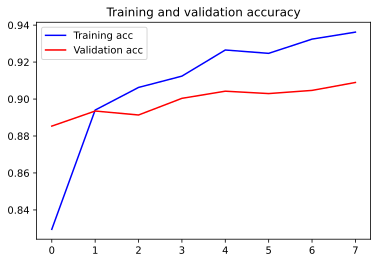

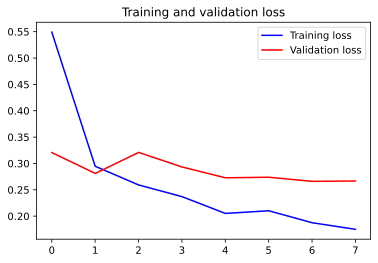

In [53]:
# Посмотрим на графики обучения:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [39]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Submission

In [54]:
# готовим данные для сабмишона на каггле
test_sub_generator.samples

6675

In [55]:
test_sub_generator.reset()

In [56]:
# Добавим ТТА
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

105/105 [==============================] - 44s 417ms/step


In [57]:
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

105/105 [==============================] - 43s 410ms/step


In [58]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [59]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [60]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv